In [1]:
import open3d as o3d
import numpy as np
import random
from sklearn.neighbors import NearestNeighbors
import pandas as pd
from sklearn.manifold import MDS
from matplotlib import pyplot as plt
import os

from f_extract_buried_points import extract_buried_points
from f_extract_surface_patch import *
from f_visualize_pointcloud import visualize_pointcloud

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


### Import the data generated by MaSIF-site

In [2]:
# Import the coordinates and the features that have been generated by dMaSIF-site of the following proteins
#   - Subunit A (IgG Fc)
#   - Subunit C (GB1 protein)
#   - Complex (Subunit A and C combined)

%cd -q masif_site_outputs
coords_A = np.load("1fcc_A_predcoords.npy")
features_A = np.load("1fcc_A_predfeatures_emb1.npy")

coords_C = np.load("1fcc_C_predcoords.npy")
features_C = np.load("1fcc_C_predfeatures_emb1.npy")

coords_complex = np.load("1fcc_A, C_predcoords.npy")
features_complex = np.load("1fcc_A, C_predfeatures_emb1.npy")

In [3]:
visualize_pointcloud(coords_C)
visualize_pointcloud(coords_A)
visualize_pointcloud(coords_complex)

### Compute Buried Surface of Both Proteins

In [4]:
buried_A, center_A = extract_buried_points(coords_A, coords_complex, 2)
buried_C, center_C = extract_buried_points(coords_C, coords_complex, 2)

In [5]:
blue = [0, 0.5, 1]
red = [1, 0, 0]
green = [0, 1, 0]

colors_A = np.zeros_like(coords_A)
colors_A[:] = blue
colors_A[buried_A] = red
colors_A[center_A] = green

visualize_pointcloud(coords_A, colors = colors_A)

colors_C = np.zeros_like(coords_C)
colors_C[:] = blue
colors_C[buried_C] = red
colors_C[center_C] = green

visualize_pointcloud(coords_C, colors = colors_C)

### Extract a patch of fixed geodesic radius from the center of the buried surfaces of both proteins

In [6]:
patch_indeces, patch_coords, pairwise_distances, first_sel = extract_surface_patch(coords_A, center_A, 12) #REMOVE FIRST SEL Here
patch_A = {}
patch_A["indeces"] = patch_indeces
patch_A["coords"] = patch_coords
patch_A["distance_matrix"] = pairwise_distances
patch_A["features"]=features_A[patch_A["indeces"]]
patch_A["first_sel"]=first_sel

In [7]:
patch_indeces, patch_coords, pairwise_distances, first_sel = extract_surface_patch(coords_C, center_C, 12)
patch_C = {}
patch_C["indeces"] = patch_indeces
patch_C["coords"] = patch_coords
patch_C["distance_matrix"] = pairwise_distances
patch_C["features"]=features_C[patch_C["indeces"]]
patch_C["first_sel"]=first_sel

In [8]:
colors_A[patch_A["indeces"]]= green
visualize_pointcloud(coords_A, colors = colors_A)

colors_C[patch_C["indeces"]]= green
visualize_pointcloud(coords_C, colors = colors_C)

[Open3D WARNING] GLFW Error: WGL: Failed to make context current: The handle is invalid. 


In [9]:
#Visualize the patches alone
#visualize_pointcloud(patch_C["coords"])
#visualize_pointcloud(patch_A["coords"])

### Embedding in 2D with MDS

In [9]:
# Using the Euclidean Distances

mds = MDS(random_state=0) #dissimilarity='precomputed'
# Get the embeddings
embedding_A = mds.fit_transform(patch_A["coords"]) #patch_A["distance_matrix"]
embedding_C = mds.fit_transform(patch_C["coords"]) #patch_C["distance_matrix"]

In [11]:
#Using the Geodesic Distances

mds = MDS(dissimilarity='precomputed', random_state=0)
# Get the embeddings
embedding_A = mds.fit_transform(patch_A["distance_matrix"])
embedding_C = mds.fit_transform(patch_C["distance_matrix"])

Text(0.5, 1.0, 'Embedding of Patch from chain A')

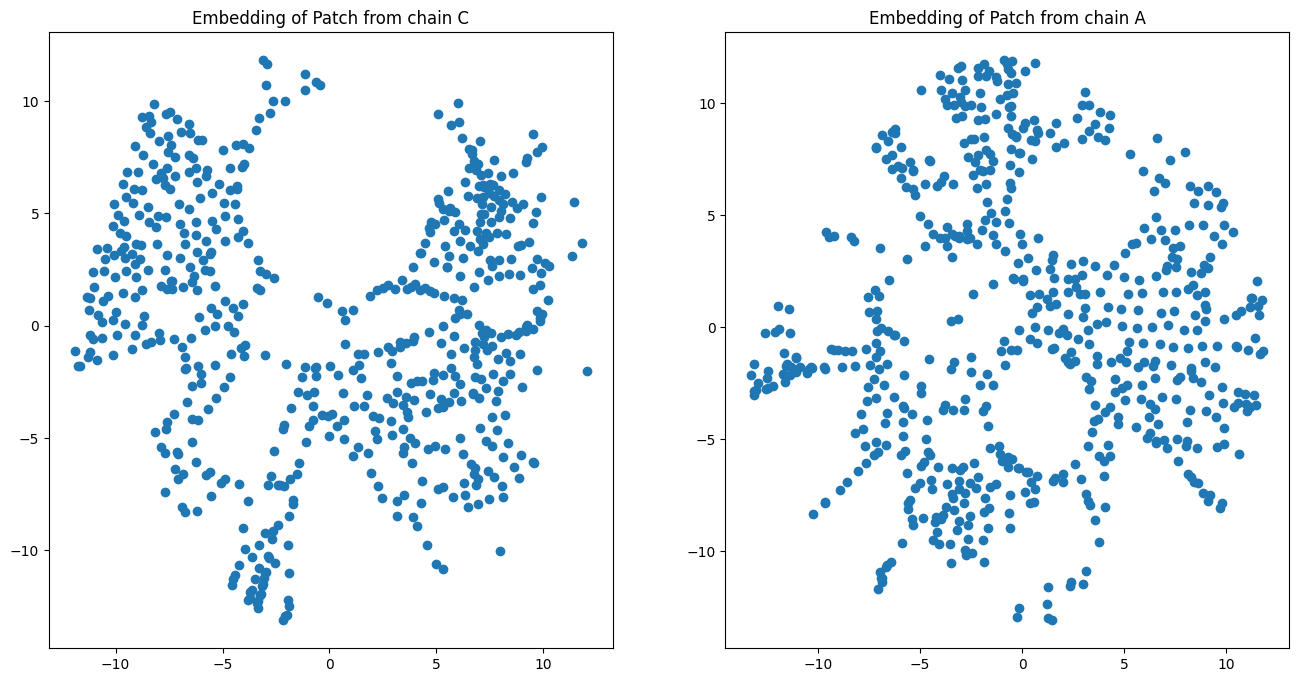

In [12]:
fig, ax = plt.subplots(2, 2, figsize=(16,8))

plt.subplot(1,2,1)
plt.scatter(embedding_C[:,0], embedding_C[:,1])
plt.title("Embedding of Patch from chain C")

plt.subplot(1,2,2)
plt.scatter(embedding_A[:,0], embedding_A[:,1])
plt.title("Embedding of Patch from chain A")

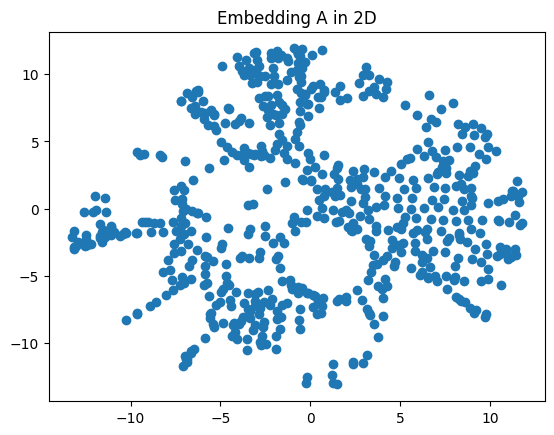

In [12]:
plt.scatter(embedding_A[:,0], embedding_A[:,1])
plt.title('Embedding A in 2D')
plt.show()


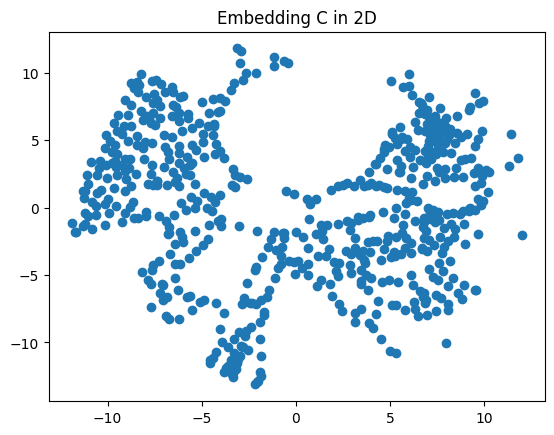

In [13]:
plt.scatter(embedding_C[:,0], embedding_C[:,1])
plt.title('Embedding C in 2D')
plt.show()

In [41]:
colors_A_test = np.zeros_like(coords_A[patch_A["first_sel"]])
colors_A_test[:] = blue
to_make_red = patch_A["indeces"]
for ind, member in enumerate(patch_A["first_sel"]):
    if member in to_make_red:
        colors_A_test[ind]=red

visualize_pointcloud(coords_A[patch_A["first_sel"]], colors = colors_A_test)


[Open3D WARNING] GLFW Error: WGL: Failed to make context current: The requested transformation operation is not supported. 


In [40]:
colors_C_test = np.zeros_like(coords_C[patch_C["first_sel"]])
colors_C_test[:] = blue
to_make_red = patch_C["indeces"]
for ind, member in enumerate(patch_C["first_sel"]):
    if member in to_make_red:
        colors_C_test[ind]=red

visualize_pointcloud(coords_C[patch_C["first_sel"]], colors = colors_C_test)


In [16]:
features_A = patch_A["features"][:, 16:32]
features_C = patch_C["features"][:, 16:32]

Text(0.5, 1.0, 'Embedding of Patch from chain A')

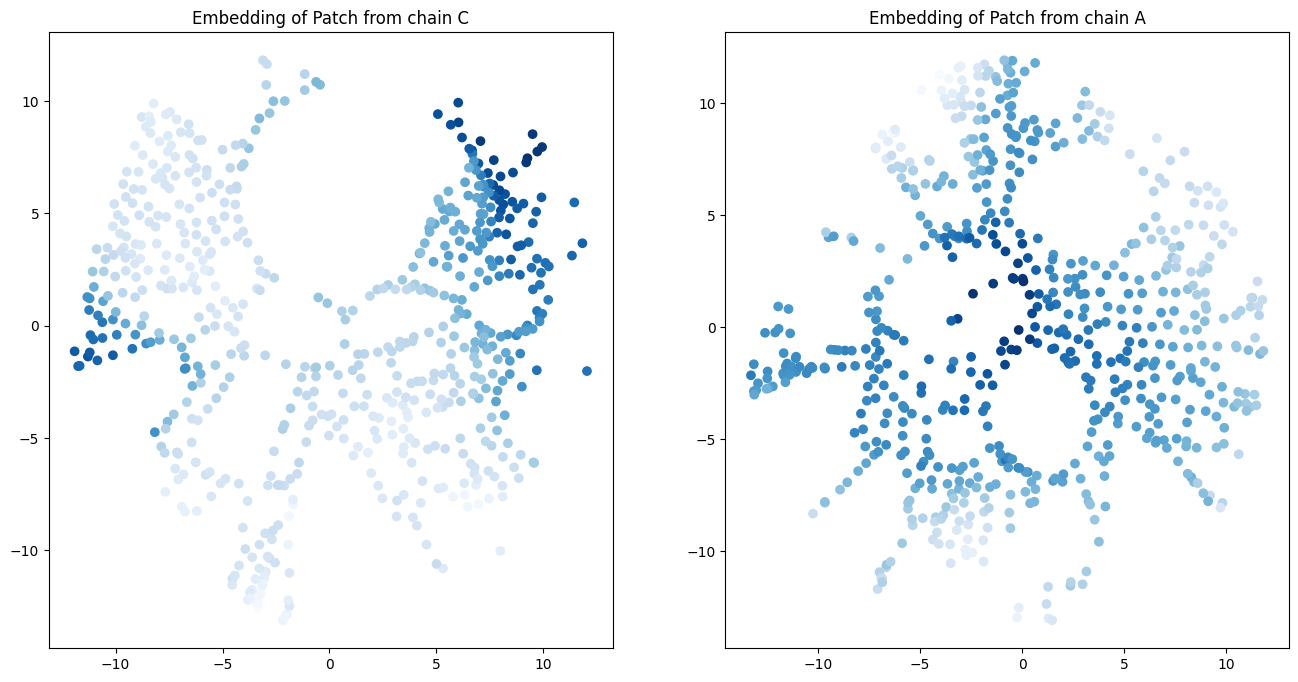

In [37]:
feature = 9

fig, ax = plt.subplots(2, 2, figsize=(16,8))

plt.subplot(1,2,1)
plt.scatter(embedding_C[:,0], embedding_C[:,1], c = features_C[:,feature], cmap = "Blues")
plt.title("Embedding of Patch from chain C")

plt.subplot(1,2,2)
plt.scatter(embedding_A[:,0], embedding_A[:,1], c = features_A[:,feature], cmap = "Blues")
plt.title("Embedding of Patch from chain A")

In [29]:
def convert_to_polar(x, y):
    r = np.sqrt(x**2 + y**2)
    phi = np.arctan2(y, x)
    return [r, phi]

In [31]:
polar_coords = []
for line in embedding_A: 
    polar_coords.append(convert_to_polar(line[0], line[1]))
np.asarray(polar_coords)
    

array([[ 1.13699602, -2.06153647],
       [11.81387085,  1.51736904],
       [11.77581818,  1.63253152],
       ...,
       [ 8.98904926, -1.1004934 ],
       [11.97693377, -0.7068489 ],
       [11.56518335, -0.69648056]])